In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# https://www.kaggle.com/code/sombersomni/finetuned-resnet-classifier-in-pytorch-97

In [2]:
root_path = 'kaggle/10BigCats'
wildcats_data = pd.read_csv(f'{root_path}/WILDCATS.CSV')
# 只看前五個
wildcats_data.head()

,class id,filepaths,labels,data set,scientific name
0,0,train/AFRICAN LEOPARD/001.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
1,0,train/AFRICAN LEOPARD/002.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
2,0,train/AFRICAN LEOPARD/003.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
3,0,train/AFRICAN LEOPARD/004.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
4,0,train/AFRICAN LEOPARD/005.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus


In [3]:
import torch
torch.manual_seed(888)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device:{device}')

device:cuda


In [4]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import os

In [5]:
class BigCatDataset(Dataset):
    def __init__(self, data, data_augmentation=False):
        self.data = data.reset_index(drop=True)

        nor_tansforms_list = [
            transforms.ConvertImageDtype(torch.float),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ]
        if data_augmentation:
            final_tansforms_list = nor_tansforms_list
        else:
            final_tansforms_list = nor_tansforms_list + [transforms.RandomHorizontalFlip()]
        self.final_tansforms = transforms.Compose(final_tansforms_list)
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # 分類編號
        class_id = self.data.loc[idx, 'class id']
        # 檔案位置
        file_path = self.data.loc[idx, 'filepaths']
        name = self.data.loc[idx, 'labels']
        full_path = os.path.join(root_path, file_path)
        with Image.open(full_path) as img:
            img = transforms.functional.pil_to_tensor(img)
            img = transforms.functional.rotate(img, 90)
            img_input = self.final_tansforms(img)
            img_show = img.transpose(2,0).detach().numpy()
        
        sample ={'targets':class_id, 'inputs': img_input, 'images':img_show, 'names': name}
        return sample

In [6]:
# Let's separate each data set
train_data = wildcats_data[wildcats_data['data set'] == 'train']
test_data = wildcats_data[wildcats_data['data set'] == 'test']
valid_data = wildcats_data[wildcats_data['data set'] == 'valid']
len(train_data), len(test_data), len(valid_data)

(2339, 50, 50)

In [7]:
labels = test_data['labels'].unique()
print(f'lables:{labels}')

lables:['AFRICAN LEOPARD' 'CARACAL' 'CHEETAH' 'CLOUDED LEOPARD' 'JAGUAR' 'LIONS'
 'OCELOT' 'PUMA' 'SNOW LEOPARD' 'TIGER']


In [8]:
test_data_simple = test_data.groupby('labels').sample(2)
test_data_simple = test_data_simple.reset_index(drop=True)
print(test_data_simple.loc[0])

class id                                    0
filepaths          test/AFRICAN LEOPARD/4.jpg
labels                        AFRICAN LEOPARD
data set                                 test
scientific name        Panthera pardus pardus
Name: 0, dtype: object


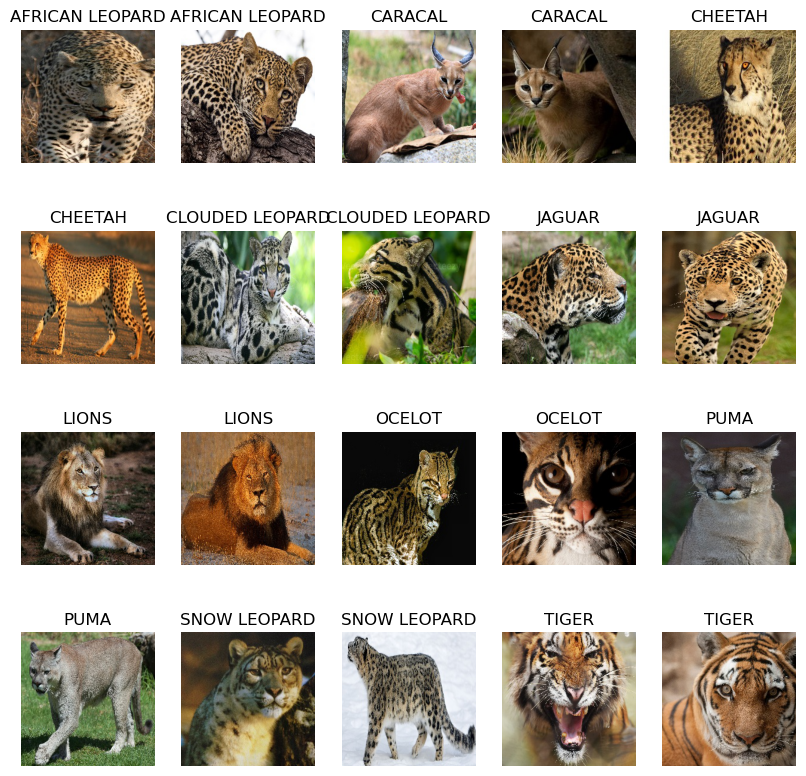

In [9]:
# 簡單觀看圖片資料
import matplotlib.pyplot as plt
labels_number = 20
fig, axes = plt.subplots(labels_number//5, 5, figsize=(10,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    full_path = os.path.join(root_path, test_data_simple.loc[i]['filepaths'])
    ax.imshow(plt.imread(full_path))
    ax.set_title(test_data_simple.loc[i]['labels'])
    ax.set_axis_off()

In [10]:
from torch.utils.data import DataLoader

batch_size = 32
train_dataloader = DataLoader(BigCatDataset(train_data, data_augmentation=True), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(BigCatDataset(test_data), batch_size=batch_size, shuffle=False)
valid_dataloader = DataLoader(BigCatDataset(valid_data), batch_size=batch_size, shuffle=False)

In [26]:
from torchvision import models
model = models.vgg16(pretrained = True)
print(model)
'''
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(25088, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(128, 10),
    torch.nn.Softmax()
)

'''

model.classifier = torch.nn.Sequential(
    torch.nn.Linear(25088, 2048),
    torch.nn.BatchNorm1d(2048),
    torch.nn.ReLU(),
    torch.nn.Linear(2048, 10)
    )

model = model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
from torchvision import models
class Model(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(Model, self).__init__()
        
        # Load the ResNet model
        resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
        # I removed this because I get better results fine tuning the model
#         for param in resnet.parameters():
#             param.requires_grad = False
        
        # Reconstruct the model without the last layer
        self.net = torch.nn.Sequential(*list(resnet.children())[:-1])
        # Build fully connected layers to handle predictions
        self.fcs = torch.nn.Sequential(
            torch.nn.Linear(2048, 2048),
            torch.nn.BatchNorm1d(2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, num_classes)
        )
        
    def forward(self, x):
        # Pass the input through the ResNext model
        x = self.net(x)
        # Flatten the output of ResNet
        x = x.view(x.shape[0], -1)
        # Send to fully connected layer
        return self.fcs(x)


In [31]:
# Setup training variables
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0
num_classes = len(wildcats_data['class id'].unique())
num_epochs = 5

model = Model(num_classes).to(device)
# Define the loss function and the optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

In [27]:
from torch import nn, optim
learning_rate = 0.001
momentum = 0.9
weight_decay = 0.0
# 定義代價函數, CrossEntropyLoss會先做一個softmax, 所以網路結構可以省一個
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
# 定義優化器
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [21]:
def train():
    # 模型的訓練狀態, dropout啟用
    model.train()
    for i, data in enumerate(train_dataloader):
        # 獲得一個批次的數據和標籤
        inputs, targets = data['inputs'].float(), data['targets'].long()
        inputs, targets = inputs.to(device), targets.to(device)
        # 獲得薄型的預測結果
        out = model(inputs)
        # 交叉商代價函數out(batch,C),C是class類別,labels(batch), 交叉商計算shape可以不一致
        loss = loss_fn(out, targets)
        # 梯度清0
        optimizer.zero_grad()
        # 計算梯度
        loss.backward()
        # 修改權值 = 更新權重
        optimizer.step()

def test():
    # 模型的測試狀態, dropout不啟用
    model.eval()
    correct=0
    for i, data in enumerate(test_dataloader):
        # 獲得一個批次的數據跟標籤
        inputs, targets = data['inputs'].float(), data['targets'].long()
        inputs, targets = inputs.to(device), targets.to(device)
        # 獲得模型與預測結果 (64, 10)
        out = model(inputs)
        # 獲得最大值, 以及最大值所在的位置,1表示第1個維度
        _, predicted = torch.max(out, 1)
        # 預測正確的位置
        correct += (predicted == targets).sum()
    print('Test acc : {0}'.format(correct.item()/len(test_data)))
    correct=0
    for i, data in enumerate(train_dataloader):
        # 獲得一個批次的數據跟標籤
        inputs, targets = data['inputs'].float(), data['targets'].long()
        inputs, targets = inputs.to(device), targets.to(device)
        # 獲得模型與預測結果 (64, 10)
        out = model(inputs)
        # 獲得最大值, 以及最大值所在的位置,1表示第1個維度
        _, predicted = torch.max(out, 1)
        # 預測正確的位置
        correct += (predicted == targets).sum()
    print('Train acc : {0}'.format(correct.item()/len(train_data)))

epoch_num = 5
for epoch in range(epoch_num):
    print('-------------------------------------------------------------------------')
    print('epoch : ',epoch)
    train()
    test()

-------------------------------------------------------------------------
epoch :  0
Test acc : 0.54
Train acc : 0.6938862761864044
-------------------------------------------------------------------------
epoch :  1
Test acc : 0.46
Train acc : 0.6750748182984181
-------------------------------------------------------------------------
epoch :  2
Test acc : 0.48
Train acc : 0.6318939717828131
-------------------------------------------------------------------------
epoch :  3
Test acc : 0.5
Train acc : 0.7161179991449337
-------------------------------------------------------------------------
epoch :  4
Test acc : 0.6
Train acc : 0.8020521590423257


In [33]:
import time
from torch.utils.tensorboard import SummaryWriter
# 設至訓練網路的一些參數
# 紀錄訓練的次數
total_train_step = 0
# 紀錄測試的次數
total_test_step = 0
# 訓練的輪數
epoch = 5


# 添加 tensorboard
writer = SummaryWriter("logs_train")

start_time = time.time()
for i in range(epoch):
    print(f'---------第 {i+1} 輪訓練開始---------')
    # 訓練步驟開始
    model.train()
    for data in train_dataloader:
        inputs, targets = data['inputs'].float(), data['targets'].long()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # 優化器優化模型
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # loss.item() 轉成 python 物件
        total_train_step = total_train_step + 1
        if total_train_step % 20 == 0:
            print(f'訓練次數: {total_train_step}, Loss: {round(loss.item(),4)}')
            writer.add_scalar('train_loss', loss.item(), total_train_step)
    end_time = time.time()
    print(f'訓練花費時間:{round(end_time-start_time, 4)}秒') 
    # 測試步驟開始
    model.eval()
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for data in test_dataloader:
            inputs, targets = data['inputs'].float(), data['targets'].long()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            total_test_loss = total_test_loss + loss.item()
            accuracy = (outputs.argmax(1) == targets).sum()
            total_accuracy = total_accuracy + accuracy
    accuracy_rate = total_accuracy.item()/len(test_data)
    print(f'整體測試集上的loss: {total_test_loss}')
    print(f'整體測試集上的正確率: {accuracy_rate}')
    writer.add_scalar('test_loss', total_test_loss, total_test_step)
    writer.add_scalar('test_accuracy', accuracy_rate, total_test_step)
    total_test_step = total_test_step + 1

    torch.save(model, f"checkpoints/10BigCats_{i}.pth")
    # torch.save(tudui.state_dict(), f"checkpoints/tudui_{i}.pth")
    print('模型已保存')


writer.close()

---------第 1 輪訓練開始---------
訓練次數: 20, Loss: 0.401
訓練次數: 40, Loss: 0.3531
訓練次數: 60, Loss: 0.3255
訓練花費時間:28.1209秒
整體測試集上的loss: 0.8759021759033203
整體測試集上的正確率: 0.88
模型已保存
---------第 2 輪訓練開始---------
訓練次數: 80, Loss: 0.3343
訓練次數: 100, Loss: 0.1858
訓練次數: 120, Loss: 0.4385
訓練次數: 140, Loss: 0.4342
訓練花費時間:59.046秒
整體測試集上的loss: 0.0849032998085022
整體測試集上的正確率: 1.0
模型已保存
---------第 3 輪訓練開始---------
訓練次數: 160, Loss: 0.0591
訓練次數: 180, Loss: 0.1563
訓練次數: 200, Loss: 0.0638
訓練次數: 220, Loss: 0.3475
訓練花費時間:89.4295秒
整體測試集上的loss: 0.5387715101242065
整體測試集上的正確率: 0.92
模型已保存
---------第 4 輪訓練開始---------
訓練次數: 240, Loss: 0.2767
訓練次數: 260, Loss: 0.1397
訓練次數: 280, Loss: 0.1974
訓練花費時間:120.3254秒
整體測試集上的loss: 0.5806114189326763
整體測試集上的正確率: 0.88
模型已保存
---------第 5 輪訓練開始---------
訓練次數: 300, Loss: 0.2135
訓練次數: 320, Loss: 0.002
訓練次數: 340, Loss: 0.0997
訓練次數: 360, Loss: 0.0694
訓練花費時間:152.6316秒
整體測試集上的loss: 0.14257134310901165
整體測試集上的正確率: 0.96
模型已保存
